## 1. Get data

We're going to start by downloading data (https://www.kaggle.com/datasets/justin900429/3d-printer-defected-dataset/code), the `3D_Defect` dataset with images of defective and non-defective images.

In [1]:
import os
import zipfile
from google.colab import drive
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "3D_Defect"

# If the image folder doesn't exist, create it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Define the dataset name
dataset_name = 'justin900429/3d-printer-defected-dataset'  # Replace with the actual dataset identifier

# Download the dataset
!kaggle datasets download -d {dataset_name} -p {str(image_path)}

# Unzip the downloaded dataset
zip_file_path = str(image_path / (dataset_name.split('/')[-1] + '.zip'))
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(image_path)

# Optionally, remove the zip file after extraction
os.remove(zip_file_path)

print(f"[INFO] Data download and extraction complete.")

Did not find data/3D_Defect directory, creating one...
Dataset URL: https://www.kaggle.com/datasets/justin900429/3d-printer-defected-dataset
License(s): CC-BY-SA-4.0
 63% 33.0M/52.8M [00:00<00:00, 73.3MB/s]
100% 52.8M/52.8M [00:00<00:00, 88.9MB/s]
[INFO] Data download and extraction complete.


In [2]:
# Create new directories to make datasets
from pathlib import Path

# Setup paths for new directory structure
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create directories
for path in [train_dir / "defected", train_dir / "not_defected", test_dir / "defected", test_dir / "not_defected"]:
    path.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Directory structure created.")

[INFO] Directory structure created.


In [3]:
# Verify directory contents
def verify_directory_contents(directory_path):
    files = list(Path(directory_path).glob('*'))
    if not files:
        print(f"No files found in {directory_path}.")
    else:
        print(f"Found {len(files)} files in {directory_path}.")
    return files

# Check paths
defected_files = verify_directory_contents(image_path / "defected")
not_defected_files = verify_directory_contents(image_path / "no_defected")

Found 759 files in data/3D_Defect/defected.
Found 798 files in data/3D_Defect/no_defected.


In [4]:
# split data and move it into respective folders
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

def move_files(file_list, destination_folder):
    for file in file_list:
        if file.exists():
          # print(f"File {file} already exists. Overwriting...")
          shutil.copy2(file, destination_folder)
        else:
          shutil.move(file, destination_folder)


def split_and_move_data(source_folder, train_folder, test_folder, train_size=0.8):
    # Get all file paths
    files = list(Path(source_folder).glob('*.jpg'))

    # Split files into train and test
    train_files, test_files = train_test_split(files, train_size=train_size, random_state=42)

    # Move files to respective folders
    move_files(train_files, train_folder)
    move_files(test_files, test_folder)

# Paths for defected and not defected datasets
defected_path = image_path / "defected"
not_defected_path = image_path / "no_defected"

# Split and move defected and not defected images
split_and_move_data(defected_path, train_dir / "defected", test_dir / "defected")
split_and_move_data(not_defected_path, train_dir / "not_defected", test_dir / "not_defected")

print(f"[INFO] Data split and moved.")

[INFO] Data split and moved.


In [5]:
print(f"Number of images in Train/defected:", len(os.listdir(train_dir / "defected")))
print(f"Number of images in Test/defected:", len(os.listdir(test_dir / "defected")))
print(f"Number of images in Train/not_defected:", len(os.listdir(train_dir / "not_defected")))
print(f"Number of images in Test/not_defected:", len(os.listdir(test_dir / "not_defected")))

print(f"Total number of images in Train:", len(os.listdir(train_dir/ "defected")) + len(os.listdir(train_dir/ "not_defected")))
print(f"Total number of images in Test:", len(os.listdir(test_dir/"defected"))  + len(os.listdir(test_dir/"not_defected")))
print(f"Total number of images:", len(os.listdir(train_dir/ "defected")) + len(os.listdir(train_dir/ "not_defected")) + len(os.listdir(test_dir/"defected"))  + len(os.listdir(test_dir/"not_defected")))

Number of images in Train/defected: 607
Number of images in Test/defected: 152
Number of images in Train/not_defected: 638
Number of images in Test/not_defected: 160
Total number of images in Train: 1245
Total number of images in Test: 312
Total number of images: 1557


In [6]:
def remove_directory(directory_path):
    try:
        if directory_path.exists():
            # Remove directory and all its contents
            shutil.rmtree(directory_path)
            print(f"Removed directory and all its contents: {directory_path}")
        else:
            print(f"Directory {directory_path} does not exist.")
    except Exception as e:
        print(f"Error: {e}")

remove_directory(image_path / "defected")
remove_directory(image_path / "no_defected")

Removed directory and all its contents: data/3D_Defect/defected
Removed directory and all its contents: data/3D_Defect/no_defected


## 2. Create Datasets and DataLoaders

Now we'll turn the image dataset into PyTorch `Dataset`'s and `DataLoader`'s.

In [7]:
from torchvision import datasets, transforms

# Create simple transform
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1245
    Root location: data/3D_Defect/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 312
    Root location: data/3D_Defect/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [8]:
# Get class names as a list
class_names = train_data.classes
class_names

['defected', 'not_defected']

In [9]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'defected': 0, 'not_defected': 1}

In [10]:
# Check the lengths
len(train_data), len(test_data)

(1245, 312)

In [11]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x77fd24d995d0>,
 <torch.utils.data.dataloader.DataLoader at 0x77fd24d9b3d0>)

In [12]:
# Check out single image size/shape
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 3. Making a model (CNN)

Creating a basic CNN model

In [13]:
import torch

from torch import nn

class CNN(nn.Module):
  """Creates the Defect-Net architecture.

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image
                    stride=1, # default
                    padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.conv_block_3 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*6*6,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.conv_block_3(x)
      x = self.classifier(x)
      return x
      # return self.classifier(self.block_2(self.block_1(x)))

In [14]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model
torch.manual_seed(42)
model_0 = CNN(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=360, out_features=2, bias=True)
  )
)

To test our model let's do a single forward pass (pass a sample batch from the training set through our model).

In [15]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0149, 0.0035]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5029, 0.4971]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


## 4. Creating `train_step()` and `test_step()` functions and `train()` to combine them  


In [16]:
from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

Now we'll do `test_step()`.

In [17]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

And we'll combine `train_step()` and `test_step()` into `train()`.

In [18]:
from typing import Dict, List

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

## 5. Creating a function to save the model

Let's setup a function to save our model to a directory.

In [19]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

## 6. Train, evaluate and save the model

Let's leverage the functions we've got above to train, test and save a model to file.


In [20]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_1 = CNN(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# Save the model
save_model(model=model_1,
           target_dir="models",
           model_name="defectnet_CNN.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6863 | train_acc: 0.5920 | test_loss: 0.6618 | test_acc: 0.5844
Epoch: 2 | train_loss: 0.5417 | train_acc: 0.7406 | test_loss: 0.4629 | test_acc: 0.7438
Epoch: 3 | train_loss: 0.4036 | train_acc: 0.8217 | test_loss: 0.3641 | test_acc: 0.8594
Epoch: 4 | train_loss: 0.3222 | train_acc: 0.8781 | test_loss: 0.3043 | test_acc: 0.8323
Epoch: 5 | train_loss: 0.2968 | train_acc: 0.8683 | test_loss: 0.3014 | test_acc: 0.8677
Epoch: 6 | train_loss: 0.2112 | train_acc: 0.9149 | test_loss: 0.2122 | test_acc: 0.8844
Epoch: 7 | train_loss: 0.1601 | train_acc: 0.9276 | test_loss: 0.2005 | test_acc: 0.9146
Epoch: 8 | train_loss: 0.1497 | train_acc: 0.9413 | test_loss: 0.1627 | test_acc: 0.9240
Epoch: 9 | train_loss: 0.1223 | train_acc: 0.9542 | test_loss: 0.1430 | test_acc: 0.9333
Epoch: 10 | train_loss: 0.1017 | train_acc: 0.9678 | test_loss: 0.1129 | test_acc: 0.9552
[INFO] Total training time: 55.493 seconds
[INFO] Saving model to: models/defectnet_CNN.pth


In [21]:
# Plot loss curves of a model
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

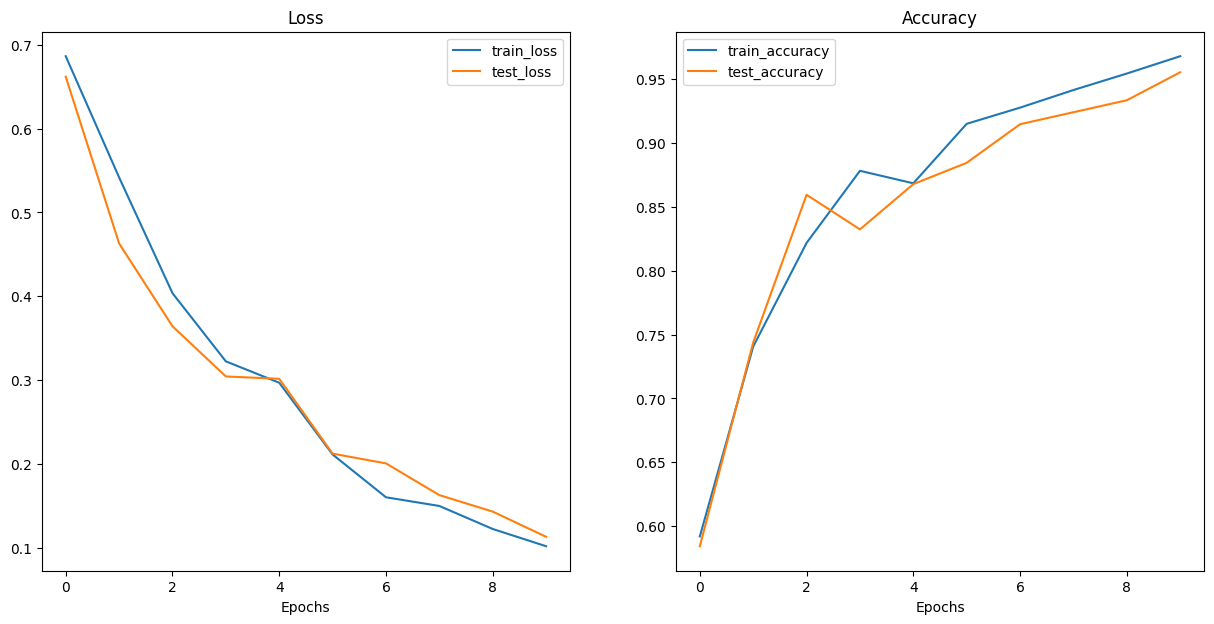

In [22]:
plot_loss_curves(model_1_results)

In [23]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Turn on model evaluation mode and inference mode
  model_1.eval()
  with torch.inference_mode():
      # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = data_transform(img).unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model_1(transformed_image.to(device))

  # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return  target_image_pred_probs, target_image_pred_label, pred_time

Example test data path: data/3D_Defect/test/not_defected/scratch_2_103.jpg
[INFO] Predicting on image at path: data/3D_Defect/test/not_defected/scratch_3_137.jpg

tensor([[0.0017, 0.9983]], device='cuda:0')
0.0048


(-0.5, 639.5, 479.5, -0.5)

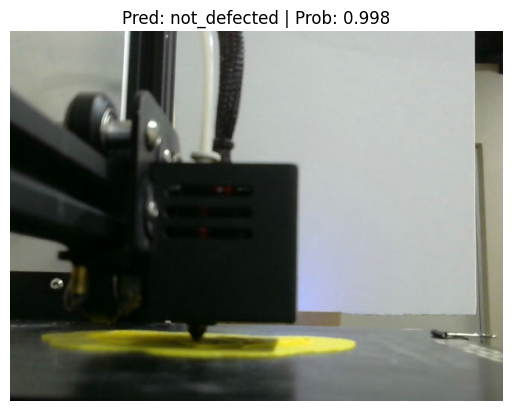

In [24]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_probs, pred_label, pred_time = predict(img=image)
print(pred_probs)
print(pred_time)

# Plot image with predicted label and probability
plt.figure()
plt.imshow(image)
plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_probs.max():.3f}")
plt.axis(False)

In [25]:
import shutil
from pathlib import Path

# Create an examples directory
defect_net_examples_path =  Path("examples/")
defect_net_examples_path.mkdir(parents=True,
                                    exist_ok=True)

# Collect three random test dataset image paths
defect_net_examples = [Path('data/3D_Defect/test/defected/bed_not_stick_12.jpg'),
                            Path('data/3D_Defect/test/defected/bed_not_stick_46.jpg'),
                            Path('data/3D_Defect/test/not_defected/scratch_12.jpg')]

# Copy the three images to the examples directory
for example in defect_net_examples:
  destination = defect_net_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/3D_Defect/test/defected/bed_not_stick_12.jpg to examples/bed_not_stick_12.jpg
[INFO] Copying data/3D_Defect/test/defected/bed_not_stick_46.jpg to examples/bed_not_stick_46.jpg
[INFO] Copying data/3D_Defect/test/not_defected/scratch_12.jpg to examples/scratch_12.jpg


In [26]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 41.

In [27]:
# 1. Imports and class names setup ###
import gradio as gr
import os
import torch
from torchvision import transforms
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['defected', 'not_defected']

# 2. Model and transforms preparation
defectnet = CNN(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)).to("cpu")

defectnet_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                          transforms.ToTensor()])

# Load save weights
defectnet.load_state_dict(
    torch.load(
        f="/content/models/defectnet_CNN.pth",
        map_location=torch.device("cpu") # load the model to the cpu
    )
)

# 3. Predict function

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with defectnet
  img = defectnet_transforms(img).unsqueeze(0) # add batch dimension

  # Put model into eval mode, make prediction
  defectnet.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into probability
    pred_probs = torch.softmax(defectnet(img), dim=1)

  # Creating a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

# 4. Gradio app

# Create title, description and article strings
title = "Defect - Net"
description = "A CNN based 3D printer defect detection"
article = "Created at ."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://45fdca2f0f1ae9f301.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
